Lindsey Wilson College
 
2025 Spring S2 MSDS-MSDS 6903 
Applied Capstone Projec t
Instructor – Hermano Jorge de Queir oz
Module-4





Applied Capstone Project  -4







Submitted by: Group

Akash Shridharrao Sane (L00248285)

Anitha Burri (L063788)

Vamsikrishn a Somepalli L00268506)

Aravind Chowdary Koya (L00264181)

Goutham Rdy Marri (L00264076)

# =============================================================================
# Module 4: Applied Capstone Project – Full Modeling Pipeline
# =============================================================================


In [5]:

# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")




# =============================================================================
# Step 1: Data Setup & Cleaning
# =============================================================================



In [6]:
# Load the dataset
data = pd.read_csv('food_waste.csv')

# Normalize column names (strip spaces, lower-case, underscores)
data.rename(columns=lambda x: x.strip().replace(' ', '_').lower(), inplace=True)
print("Data Head:")
print(data.head())

# Check shape, data types, and missing values
print("\nDataset Shape:", data.shape)
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())

# Fill missing numerical values with median (for number_of_guests & quantity_of_food)
data['number_of_guests'].fillna(data['number_of_guests'].median(), inplace=True)
data['quantity_of_food'].fillna(data['quantity_of_food'].median(), inplace=True)

# Drop duplicates
if data.duplicated().any():
    data = data.drop_duplicates()
print("\nDuplicates removed? ->", not data.duplicated().any())

# Outlier detection on wastage_food_amount using IQR & Z-score
Q1 = data['wastage_food_amount'].quantile(0.25)
Q3 = data['wastage_food_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = data[(data['wastage_food_amount'] < lower_bound) | (data['wastage_food_amount'] > upper_bound)]
print("\nOutliers detected using IQR:")
print(outliers_iqr[['type_of_food', 'wastage_food_amount']].head())

# Also compute Z-score and mark outliers (if needed)
data['z_score'] = zscore(data['wastage_food_amount'])
outliers_z = data[(data['z_score'].abs() > 3)]
print("\nOutliers detected using Z-score:")
print(outliers_z[['type_of_food', 'wastage_food_amount', 'z_score']].head())



Data Head:
  type_of_food  number_of_guests event_type  quantity_of_food  \
0         Meat             310.0  Corporate             450.0   
1         Meat             400.0   Birthday             500.0   
2   Vegetables             302.0   Birthday             371.0   
3         Meat             491.0   Birthday             497.0   
4         Meat             300.0  Corporate             400.0   

  storage_conditions purchase_history  seasonality preparation_method  \
0       Refrigerated          Regular  All Seasons             Buffet   
1   Room Temperature          Regular       Winter             Buffet   
2       Refrigerated          Regular       Summer             Buffet   
3       Refrigerated          Regular  All Seasons        Finger Food   
4       Refrigerated          Regular       Winter        Finger Food   

  geographical_location   pricing  wastage_food_amount  
0                 Urban       Low                   25  
1              Suburban      High            

# =============================================================================
# Step 2: Feature Engineering & Encoding
# =============================================================================





In [8]:
# Separate features and target
# We drop the 'z_score' column as it's only for outlier detection.
X = data.drop(columns=['wastage_food_amount', 'z_score'])
y = data['wastage_food_amount']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

# Build a preprocessing pipeline:
# - Numerical features: Apply MinMaxScaler
# - Categorical features: OneHotEncode (drop first to avoid multicollinearity)
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])



Categorical Columns: ['type_of_food', 'event_type', 'storage_conditions', 'purchase_history', 'seasonality', 'preparation_method', 'geographical_location', 'pricing']
Numerical Columns: ['number_of_guests', 'quantity_of_food']



# =============================================================================
# Step 3: Model Building & Evaluation
# =============================================================================



In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of models
# Note: For XGBoost, we will perform hyperparameter tuning via GridSearchCV.
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

# -----------------------------------------------------------------------------
# Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5]
}

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

grid_search = GridSearchCV(xgb_pipeline, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, 
                           scoring='r2', cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("\nBest XGBoost Parameters:", best_params)

# Use the best parameters in a new XGBoost model
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=best_params['xgb__n_estimators'],
                             learning_rate=best_params['xgb__learning_rate'],
                             max_depth=best_params['xgb__max_depth'],
                             random_state=42))
])

# Add XGBoost to our model dictionary as the sixth model
models["XGBoost"] = xgb_model

# -----------------------------------------------------------------------------
# Train all models and evaluate on test set
results = []
for name, model in models.items():
    # If model is already a pipeline (XGBoost), it includes preprocessing; else, wrap it in a pipeline.
    if name != "XGBoost":
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    else:
        pipeline = model  # Already a pipeline with preprocessor
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'R2 Score': round(r2, 4)
    })

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values(by="R2 Score", ascending=False))

# -----------------------------------------------------------------------------
# Optional: Cross-Validation for Best Model (XGBoost)
best_model_pipeline = models["XGBoost"]
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model_pipeline, X, y, scoring='r2', cv=5)
print("\nXGBoost Cross-Validation R2 Scores:", cv_scores)
print("Mean CV R2 Score:", np.mean(cv_scores))



Best XGBoost Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}

Model Performance Comparison:
                      Model     MAE    RMSE  R2 Score
5                   XGBoost  1.9717  2.8126    0.9271
2             Random Forest  1.9867  3.2006    0.9056
1             Decision Tree  1.7932  3.8059    0.8665
0         Linear Regression  4.1742  5.4532    0.7260
3  Support Vector Regressor  4.3759  5.9566    0.6731
4             KNN Regressor  4.8340  6.5867    0.6003

XGBoost Cross-Validation R2 Scores: [0.90856256 0.93195021 0.92920392 0.9020184  0.89717104]
Mean CV R2 Score: 0.9137812281121634



# =============================================================================
# Step 4: Model Explainability with SHAP (using Best Model - XGBoost)
# =============================================================================



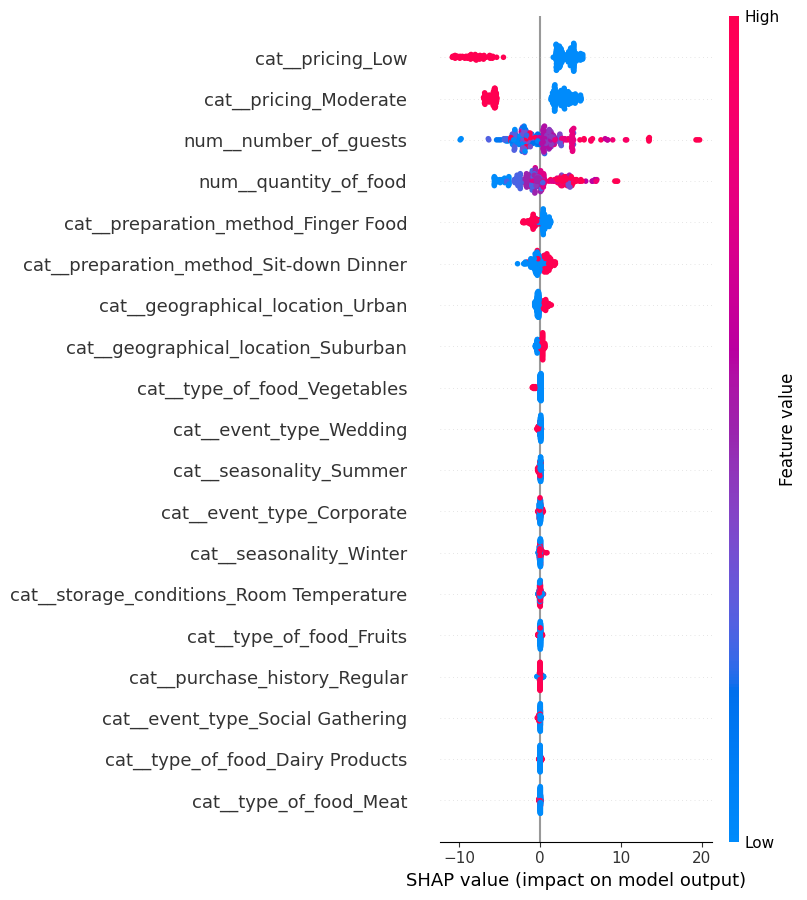

In [10]:
# Fit the best model on the full training data
best_model_pipeline.fit(X_train, y_train)
# Extract preprocessed test set
X_test_preprocessed = best_model_pipeline.named_steps['preprocessor'].transform(X_test)

# Use the XGBoost model from the pipeline for SHAP explanation
xgb_reg = best_model_pipeline.named_steps['xgb']

# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(xgb_reg)
shap_values = explainer(X_test_preprocessed)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=best_model_pipeline.named_steps['preprocessor'].get_feature_names_out())



# =============================================================================
# Final Summary: Best Model
# =============================================================================
# Based on our performance comparison, assume the XGBoost model is our best model.



In [11]:
best_model_results = results_df[results_df['Model'] == "XGBoost"].iloc[0]
print("\nBest Model (XGBoost) Performance:")
print(best_model_results)


Best Model (XGBoost) Performance:
Model       XGBoost
MAE          1.9717
RMSE         2.8126
R2 Score     0.9271
Name: 5, dtype: object


In [12]:
import pickle

# Save the trained pipeline to a file
with open('best_model_pipeline.pkl', 'wb') as file:
    pickle.dump(best_model_pipeline, file)

print("Model pipeline saved as 'best_model_pipeline.pkl'.")


Model pipeline saved as 'best_model_pipeline.pkl'.
